In [ ]:
import numpy as np
import pandas as pd
from functools import reduce
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ParameterGrid, cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFE
from sklearn.base import clone
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import time


In [13]:
# -------------------------------
# Step 1: Load and Clean WHQ_df (with BMI Calculation)
# -------------------------------
WHQ_df = pd.read_csv('WHQ_L.csv')

# Replace the placeholder values (7777, 9999, and blanks) with NaN
WHQ_df.replace({7777: np.nan, 9999: np.nan}, inplace=True)
WHQ_df.replace(r'^\s*$', np.nan, regex=True, inplace=True)
WHQ_df.dropna(inplace=True)

# Calculate BMI using the formula: BMI = (weight in lbs / (height in inches)^2) * 703
WHQ_df['BMI'] = (WHQ_df['WHD020'] / (WHQ_df['WHD010'] ** 2)) * 703

# Define a function to classify BMI
def classify_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif bmi < 25:
        return 'Healthy Weight'
    elif bmi < 30:
        return 'Overweight'
    elif bmi < 35:
        return 'Class 1 Obesity'
    elif bmi < 40:
        return 'Class 2 Obesity'
    else:
        return 'Class 3 Obesity'

# Apply the classification to create a new column
WHQ_df['BMI_category'] = WHQ_df['BMI'].apply(classify_bmi)

WHQ_df.drop(['WHD010', 'WHD020', 'WHD050', 'WHQ070', 'BMI'], axis=1, inplace=True)

print("First few rows of cleaned WHQ_df:")
print(WHQ_df.head())


First few rows of cleaned WHQ_df:
       SEQN     BMI_category
0  130378.0       Overweight
1  130379.0  Class 1 Obesity
2  130380.0       Overweight
3  130384.0  Class 1 Obesity
4  130385.0  Class 1 Obesity


In [14]:
# -------------------------------
# Step 2: Load the Other DataFrames
# -------------------------------
ALQ_df    = pd.read_csv('ALQ_L.csv')
BAX_df    = pd.read_csv('BAX_L.csv')
#BMX_df    = pd.read_csv('BMX_L.csv')
BPQ_df    = pd.read_csv('BPQ_L.csv')
BPXO_df   = pd.read_csv('BPXO_L.csv')
DBQ_df    = pd.read_csv('DBQ_L.csv')
DEMO_df   = pd.read_csv('DEMO_L.csv')
DR1IFF_df = pd.read_csv('DR1IFF_L.csv')
MCQ_df    = pd.read_csv('MCQ_L.csv')
PAQ_df    = pd.read_csv('PAQ_L.csv')
# Note: WHQ_df is already loaded and processed above.


In [15]:
# -------------------------------
# Step 3: Merge All DataFrames on 'SEQN'
# -------------------------------
dfs = [ALQ_df, BAX_df, BPQ_df, BPXO_df, DBQ_df, DEMO_df, DR1IFF_df, MCQ_df, PAQ_df, WHQ_df]
merged_df = reduce(lambda left, right: pd.merge(left, right, on='SEQN', how='outer'), dfs)

print("Columns in merged_df:")
print(merged_df.columns)

Columns in merged_df:
Index(['SEQN', 'ALQ111', 'ALQ121', 'ALQ130', 'ALQ142', 'ALQ270', 'ALQ280',
       'ALQ151', 'ALQ170', 'BAXMSTAT',
       ...
       'MCQ230D', 'OSQ230', 'PAD790Q', 'PAD790U', 'PAD800', 'PAD810Q',
       'PAD810U', 'PAD820', 'PAD680', 'BMI_category'],
      dtype='object', length=246)


In [16]:
# -------------------------------
# Step 4: Clean Merged Data
# -------------------------------
# Drop rows missing the target 'BMI_category'
merged_df.dropna(subset=['BMI_category'], inplace=True)

# Fill missing values with 0 for all remaining columns
merged_df.fillna(0, inplace=True)



In [17]:
# -------------------------------
# Step 5: Prepare Features and Target
# -------------------------------
y = merged_df['BMI_category']
X = merged_df.drop(['BMI_category', 'SEQN'], axis=1)

# One-hot encode categorical variables in X
X = pd.get_dummies(X)

In [18]:
# -------------------------------
# Step 6: Stratified Train-Test Split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [19]:
# -------------------------------
# Step 7: Scaling Features
# -------------------------------
scaler = StandardScaler()

# Scale the training data and transform test data, preserving column names
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

In [20]:
# -------------------------------
# Step 8: Apply SMOTE to Balance the Training Data
# -------------------------------
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)
print("Training set distribution after SMOTE:")
print(pd.Series(y_train_res).value_counts())

print("\nTest set distribution (original composition):")
print(y_test.value_counts())

Training set distribution after SMOTE:
BMI_category
Overweight         21512
Class 1 Obesity    21512
Class 2 Obesity    21512
Healthy Weight     21512
Class 3 Obesity    21512
Underweight        21512
Name: count, dtype: int64

Test set distribution (original composition):
BMI_category
Overweight         5379
Healthy Weight     5042
Class 1 Obesity    2941
Class 2 Obesity    1297
Class 3 Obesity     996
Underweight         280
Name: count, dtype: int64


In [21]:
# -------------------------------
# Step 9: Multinomial Logistic Regression Model (using resampled training data)
# -------------------------------

# Initialize the multinomial logistic regression model.
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)

# Fit the model on the training data
log_reg.fit(X_train_res, y_train_res)

# Make predictions on the test data
y_pred_log_reg = log_reg.predict(X_test_scaled)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred_log_reg)
report = classification_report(y_test, y_pred_log_reg)

print("Multinomial Logistic Regression Model Accuracy:", accuracy)
print("Classification Report:\n", report)

C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Multinomial Logistic Regression Model Accuracy: 0.4822717288986508
Classification Report:
                  precision    recall  f1-score   support

Class 1 Obesity       0.42      0.42      0.42      2941
Class 2 Obesity       0.30      0.49      0.37      1297
Class 3 Obesity       0.44      0.70      0.54       996
 Healthy Weight       0.69      0.63      0.66      5042
     Overweight       0.56      0.32      0.40      5379
    Underweight       0.15      0.82      0.25       280

       accuracy                           0.48     15935
      macro avg       0.42      0.56      0.44     15935
   weighted avg       0.54      0.48      0.49     15935



In [22]:
# -------------------------------
# Step 10: Feature Selection using Permutation Feature Importance and Retraining Logistic Regression
# -------------------------------
# (We use the scaled training and test data from Cell 8.)

# Define the base logistic regression model with class weighting.
base_model = LogisticRegression(multi_class='multinomial', penalty='l2',
                                  solver='lbfgs', max_iter=600, class_weight='balanced', random_state=42)

# Desired number of features to select (updated to 14)
n_features_to_select = 14

def custom_rfe(estimator, X, y, n_features_to_select, step=5):
    """
    Custom permutation-based feature elimination: iteratively removes 'step' features per iteration
    based on the average absolute coefficient values (acting as a proxy for permutation importance)
    until only n_features_to_select remain.
    """
    n_features = X.shape[1]
    support_ = np.ones(n_features, dtype=bool)
    ranking_ = np.ones(n_features, dtype=int)
    iteration = 0
    
    while np.sum(support_) > n_features_to_select:
        iteration += 1
        estimator_clone = clone(estimator)
        estimator_clone.fit(X[:, support_], y)
        
        # Use average absolute coefficient values as a proxy for feature importance (akin to permutation importance)
        if hasattr(estimator_clone, 'coef_'):
            scores = np.mean(np.abs(estimator_clone.coef_), axis=0)
        else:
            raise ValueError("Estimator does not have coef_ attribute.")
        
        current_features_idx = np.where(support_)[0]
        n_current = len(current_features_idx)
        n_to_remove = min(step, n_current - n_features_to_select)
        
        # Identify the least important features based on the computed scores
        sorted_idx = np.argsort(scores)
        remove_idx = current_features_idx[sorted_idx[:n_to_remove]]
        
        ranking_[remove_idx] = iteration + 1
        support_[remove_idx] = False
        
        print(f"Iteration {iteration}: Removed features indices {remove_idx.tolist()}. Remaining features: {np.sum(support_)}")
    
    return support_, ranking_

# Apply custom permutation-based feature selection using the original (non-resampled) training data.
support_, ranking_ = custom_rfe(base_model, X_train_scaled.values, y_train.values, n_features_to_select, step=5)
print("Final selected features (True means selected):")
print(support_)

# Subset the training and test sets to only the selected features.
selected_columns = X_train_scaled.columns[support_]
X_train_rfe = X_train_scaled[selected_columns]
X_test_rfe = X_test_scaled[selected_columns]

# Apply SMOTE on the selected features
X_train_rfe_res, y_train_rfe_res = smote.fit_resample(X_train_rfe, y_train)

# Retrain logistic regression on the SMOTE-resampled, permutation-selected features.
lr_rfe = LogisticRegression(multi_class='multinomial', penalty='l2',
                            solver='lbfgs', max_iter=600, class_weight='balanced', random_state=42)
lr_rfe.fit(X_train_rfe_res, y_train_rfe_res)

# Evaluate on the test set using the selected features.
y_pred_rfe = lr_rfe.predict(X_test_rfe)
print("\nClassification Report with Permutation-selected Features:")
print(classification_report(y_test, y_pred_rfe))


C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Iteration 1: Removed features indices [78, 75, 76, 77, 67]. Remaining features: 252


C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Iteration 2: Removed features indices [97, 74, 73, 72, 69]. Remaining features: 247


C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Iteration 3: Removed features indices [93, 71, 70, 68, 208]. Remaining features: 242


C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Iteration 4: Removed features indices [129, 167, 179, 151, 172]. Remaining features: 237


C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Iteration 5: Removed features indices [197, 133, 146, 135, 180]. Remaining features: 232


C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Iteration 6: Removed features indices [140, 157, 154, 182, 90]. Remaining features: 227


C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Iteration 7: Removed features indices [178, 173, 158, 89, 153]. Remaining features: 222


C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Iteration 8: Removed features indices [155, 148, 169, 107, 181]. Remaining features: 217


C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Iteration 9: Removed features indices [248, 212, 138, 249, 130]. Remaining features: 212


C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Iteration 10: Removed features indices [156, 136, 207, 198, 187]. Remaining features: 207


C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Iteration 11: Removed features indices [196, 193, 168, 236, 141]. Remaining features: 202


C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Iteration 12: Removed features indices [183, 254, 124, 122, 174]. Remaining features: 197


C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Iteration 13: Removed features indices [128, 177, 132, 166, 225]. Remaining features: 192


C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Iteration 14: Removed features indices [147, 213, 234, 102, 117]. Remaining features: 187


C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Iteration 15: Removed features indices [186, 91, 126, 240, 45]. Remaining features: 182


C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Iteration 16: Removed features indices [184, 185, 220, 170, 5]. Remaining features: 177


C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Iteration 17: Removed features indices [188, 190, 171, 191, 159]. Remaining features: 172


C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Iteration 18: Removed features indices [165, 201, 143, 164, 176]. Remaining features: 167


C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Iteration 19: Removed features indices [139, 175, 4, 3, 127]. Remaining features: 162


C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Iteration 20: Removed features indices [137, 106, 30, 252, 39]. Remaining features: 157


C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Iteration 21: Removed features indices [256, 245, 251, 92, 101]. Remaining features: 152


C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Iteration 22: Removed features indices [0, 228, 48, 123, 51]. Remaining features: 147


C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Iteration 23: Removed features indices [125, 206, 163, 118, 50]. Remaining features: 142


C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Iteration 24: Removed features indices [49, 194, 227, 131, 250]. Remaining features: 137


C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Iteration 25: Removed features indices [121, 200, 199, 232, 56]. Remaining features: 132


C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Iteration 26: Removed features indices [247, 253, 32, 120, 246]. Remaining features: 127


C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Iteration 27: Removed features indices [119, 34, 238, 210, 219]. Remaining features: 122


C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Iteration 28: Removed features indices [62, 211, 24, 9, 113]. Remaining features: 117


C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Iteration 29: Removed features indices [152, 203, 100, 134, 116]. Remaining features: 112


C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Iteration 30: Removed features indices [150, 149, 202, 214, 47]. Remaining features: 107


C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Iteration 31: Removed features indices [40, 60, 223, 14, 231]. Remaining features: 102


C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Iteration 32: Removed features indices [31, 230, 33, 108, 224]. Remaining features: 97


C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Iteration 33: Removed features indices [235, 112, 109, 88, 189]. Remaining features: 92


C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Iteration 34: Removed features indices [142, 86, 27, 79, 1]. Remaining features: 87


C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Iteration 35: Removed features indices [87, 80, 6, 8, 42]. Remaining features: 82


C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Iteration 36: Removed features indices [111, 53, 43, 162, 103]. Remaining features: 77


C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Iteration 37: Removed features indices [160, 161, 99, 38, 226]. Remaining features: 72


C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Iteration 38: Removed features indices [98, 255, 10, 55, 218]. Remaining features: 67


C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Iteration 39: Removed features indices [12, 7, 25, 110, 205]. Remaining features: 62


C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Iteration 40: Removed features indices [204, 243, 46, 28, 145]. Remaining features: 57


C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Iteration 41: Removed features indices [195, 41, 44, 216, 96]. Remaining features: 52


C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Iteration 42: Removed features indices [217, 229, 144, 54, 209]. Remaining features: 47


C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Iteration 43: Removed features indices [192, 114, 35, 26, 115]. Remaining features: 42


C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Iteration 44: Removed features indices [105, 29, 61, 237, 233]. Remaining features: 37


C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Iteration 45: Removed features indices [59, 95, 215, 81, 11]. Remaining features: 32


C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Iteration 46: Removed features indices [13, 221, 65, 20, 16]. Remaining features: 27


C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Iteration 47: Removed features indices [83, 63, 22, 15, 82]. Remaining features: 22


C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Iteration 48: Removed features indices [84, 85, 58, 64, 52]. Remaining features: 17


C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Iteration 49: Removed features indices [66, 239, 17]. Remaining features: 14
Final selected features (True means selected):
[False False  True False False False False False False False False False
 False False False False False False  True  True False  True False  True
 False False False False False False False False False False False False
  True  True False False False False False False False False False False
 False False False False False False False False False  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False  True False
 False False False False False False False False  True False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False


C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Classification Report with Permutation-selected Features:
                 precision    recall  f1-score   support

Class 1 Obesity       0.33      0.85      0.47      2941
Class 2 Obesity       0.26      0.05      0.09      1297
Class 3 Obesity       0.53      0.56      0.55       996
 Healthy Weight       0.67      0.43      0.52      5042
     Overweight       0.40      0.00      0.00      5379
    Underweight       0.05      0.66      0.09       280

       accuracy                           0.34     15935
      macro avg       0.37      0.43      0.29     15935
   weighted avg       0.46      0.34      0.30     15935



Training Performance (Permutation-Selected Features):
                 precision    recall  f1-score   support

Class 1 Obesity       0.33      0.84      0.47     11763
Class 2 Obesity       0.29      0.06      0.09      5190
Class 3 Obesity       0.55      0.56      0.55      3986
 Healthy Weight       0.67      0.43      0.53     20165
     Overweight       0.71      0.00      0.00     21512
    Underweight       0.05      0.68      0.09      1120

       accuracy                           0.35     63736
      macro avg       0.43      0.43      0.29     63736
   weighted avg       0.57      0.35      0.30     63736

Test Performance (Permutation-Selected Features):
                 precision    recall  f1-score   support

Class 1 Obesity       0.33      0.85      0.47      2941
Class 2 Obesity       0.26      0.05      0.09      1297
Class 3 Obesity       0.53      0.56      0.55       996
 Healthy Weight       0.67      0.43      0.52      5042
     Overweight       0.40      0.00 

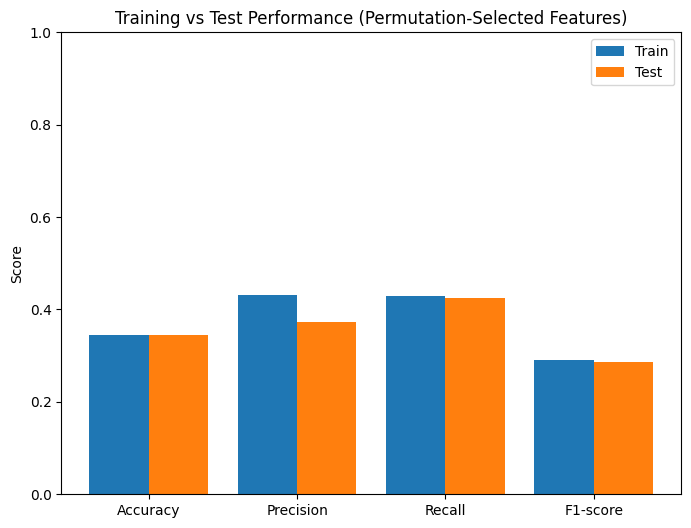

In [23]:
# -------------------------------
# Step 11: Detailed Performance Evaluation and Visualization (Using Permutation-Selected Model)
# -------------------------------

# Use the permutation-selected model (lr_rfe) to predict on the training and test sets (non-resampled)
y_pred_train_rfe = lr_rfe.predict(X_train_rfe)
y_pred_test_rfe  = lr_rfe.predict(X_test_rfe)

print("Training Performance (Permutation-Selected Features):")
print(classification_report(y_train, y_pred_train_rfe))
print("Test Performance (Permutation-Selected Features):")
print(classification_report(y_test, y_pred_test_rfe))

# Extract metrics for plotting (using output_dict=True to obtain a metrics dictionary)
train_report = classification_report(y_train, y_pred_train_rfe, output_dict=True)
test_report  = classification_report(y_test, y_pred_test_rfe, output_dict=True)

# Define metrics to plot: overall accuracy and macro averages of precision, recall, f1-score
metrics_labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']

train_scores = [
    train_report['accuracy'],
    train_report['macro avg']['precision'],
    train_report['macro avg']['recall'],
    train_report['macro avg']['f1-score']
]

test_scores = [
    test_report['accuracy'],
    test_report['macro avg']['precision'],
    test_report['macro avg']['recall'],
    test_report['macro avg']['f1-score']
]




C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ambro\AppData\Local\Programs\Python\P

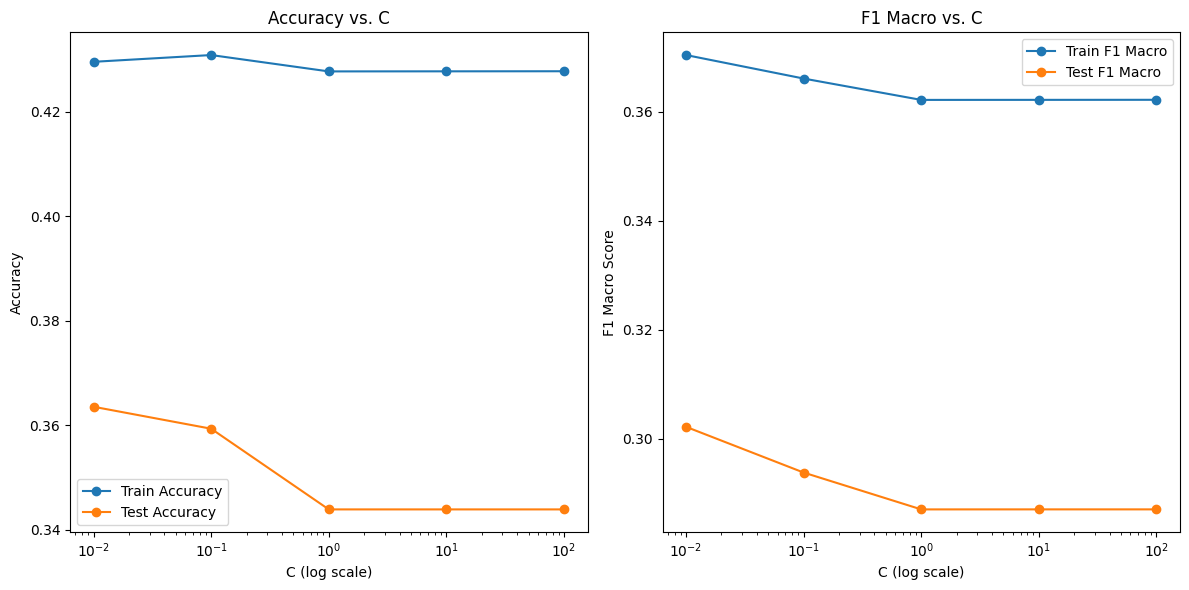

In [27]:
# -------------------------------
# Step 12: Model Sensitivity Analysis on Regularization Parameter (C)
# (Using Permutation-Selected Features)
# -------------------------------
from sklearn.metrics import f1_score

# Define a list of C values to try (inverse of regularization strength)
c_values = [0.01, 0.1, 1, 10, 100]

train_accuracies = []
test_accuracies = []
train_f1s = []
test_f1s = []

for c in c_values:
    # Initialize logistic regression with current C; use class_weight='balanced' as before
    lr_temp = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000,
                                 C=c, class_weight='balanced', random_state=42)
    # Fit on SMOTE-resampled training data for the selected features
    lr_temp.fit(X_train_rfe_res, y_train_rfe_res)
    
    # Predictions for the training set: use the resampled training data to ensure consistency
    y_pred_train_temp = lr_temp.predict(X_train_rfe_res)
    # Predictions for the test set: use the selected feature set for the test data
    y_pred_test_temp = lr_temp.predict(X_test_rfe)
    
    # Record accuracy and macro F1 score
    train_accuracies.append(accuracy_score(y_train_rfe_res, y_pred_train_temp))
    test_accuracies.append(accuracy_score(y_test, y_pred_test_temp))
    train_f1s.append(f1_score(y_train_rfe_res, y_pred_train_temp, average='macro'))
    test_f1s.append(f1_score(y_test, y_pred_test_temp, average='macro'))

# Plotting the performance metrics
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(c_values, train_accuracies, marker='o', label='Train Accuracy')
plt.plot(c_values, test_accuracies, marker='o', label='Test Accuracy')
plt.xscale('log')
plt.xlabel('C (log scale)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. C')
plt.legend()

# F1 Macro Score plot
plt.subplot(1, 2, 2)
plt.plot(c_values, train_f1s, marker='o', label='Train F1 Macro')
plt.plot(c_values, test_f1s, marker='o', label='Test F1 Macro')
plt.xscale('log')
plt.xlabel('C (log scale)')
plt.ylabel('F1 Macro Score')
plt.title('F1 Macro vs. C')
plt.legend()

plt.tight_layout()
plt.show()


In [28]:
# -------------------------------
# Step 13: Train Logistic Regression with Specific Regularization (C=0.01)
# (Using Permutation-Selected Features)
# -------------------------------
specific_c = 0.01  # You can adjust this based on the sensitivity analysis results

# Train the model on the SMOTE-resampled data using the selected features
lr_specific = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000,
                                 C=specific_c, class_weight='balanced', random_state=42)
lr_specific.fit(X_train_rfe_res, y_train_rfe_res)

# Predict on the same resampled training set and on the test set (using selected features)
y_pred_train_specific = lr_specific.predict(X_train_rfe_res)
y_pred_test_specific  = lr_specific.predict(X_test_rfe)

print("Training Performance with C = {}:".format(specific_c))
print(classification_report(y_train_rfe_res, y_pred_train_specific))
print("Test Performance with C = {}:".format(specific_c))
print(classification_report(y_test, y_pred_test_specific))


C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training Performance with C = 0.01:
                 precision    recall  f1-score   support

Class 1 Obesity       0.31      0.82      0.46     21512
Class 2 Obesity       0.42      0.08      0.13     21512
Class 3 Obesity       0.69      0.56      0.62     21512
 Healthy Weight       0.45      0.50      0.48     21512
     Overweight       0.50      0.00      0.00     21512
    Underweight       0.48      0.61      0.54     21512

       accuracy                           0.43    129072
      macro avg       0.48      0.43      0.37    129072
   weighted avg       0.48      0.43      0.37    129072

Test Performance with C = 0.01:
                 precision    recall  f1-score   support

Class 1 Obesity       0.33      0.82      0.47      2941
Class 2 Obesity       0.24      0.08      0.12      1297
Class 3 Obesity       0.53      0.57      0.55       996
 Healthy Weight       0.67      0.50      0.57      5042
     Overweight       0.31      0.00      0.00      5379
    Underweight 

In [19]:
# -------------------------------
# Step 14: Final Model with Manually Selected Features (Multinomial Logistic Regression)
# -------------------------------

# Define the manually selected features (replace these placeholders with your chosen feature names)
manual_features_lr = [
    'RIDAGEYR',
    'INDFMPIR',
    'WTMEC2YR',
    'BPXOPLS3',
    'BPXOPLS2',
    'BPXOPLS1',
    'DR1DBIH',
    'WTDRD1',
    'BPXOSY2',
    'BPXOSY3',
    'BPXOSY1',
    'DR1ILINE',
    'WTDR2D',
    'PAD680'
]

# Subset the scaled training and test data to include only the manually selected features
X_train_manual = X_train_scaled[manual_features_lr]
X_test_manual  = X_test_scaled[manual_features_lr]

# Apply SMOTE on the manually selected training data
X_train_manual_res, y_train_manual_res = smote.fit_resample(X_train_manual, y_train)

# Initialize and train logistic regression on the manual feature set
lr_manual = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000,
                               C=specific_c, class_weight='balanced', random_state=42)
lr_manual.fit(X_train_manual_res, y_train_manual_res)

# Evaluate performance
y_pred_train_manual = lr_manual.predict(X_train_manual)
y_pred_test_manual  = lr_manual.predict(X_test_manual)

print("Training Performance with manually selected features:")
print(classification_report(y_train, y_pred_train_manual))
print("Test Performance with manually selected features:")
print(classification_report(y_test, y_pred_test_manual))


C:\Users\ambro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training Performance with manually selected features:
                 precision    recall  f1-score   support

Class 1 Obesity       0.22      0.18      0.20     11763
Class 2 Obesity       0.14      0.18      0.16      5190
Class 3 Obesity       0.12      0.28      0.17      3986
 Healthy Weight       0.39      0.22      0.28     20165
     Overweight       0.39      0.22      0.28     21512
    Underweight       0.04      0.49      0.07      1120

       accuracy                           0.22     63736
      macro avg       0.22      0.26      0.19     63736
   weighted avg       0.31      0.22      0.24     63736

Test Performance with manually selected features:
                 precision    recall  f1-score   support

Class 1 Obesity       0.22      0.18      0.20      2941
Class 2 Obesity       0.14      0.18      0.16      1297
Class 3 Obesity       0.12      0.29      0.17       996
 Healthy Weight       0.37      0.20      0.26      5042
     Overweight       0.39      0.22 